In [1]:
import tensorflow as tf
import numpy as np
from time import time
from utils import plot_images, read_mnist_data
from tfops import fc, inflate, flatten, conv, deconv
from os.path import exists

In [2]:
data, _ = read_mnist_data()

Extracting data/MNIST/train-images-idx3-ubyte.gz
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz
Data shapes:
Training - x: (55000, 784), y:(55000, 10)
Test - x: (10000, 784), y:(10000, 10)
Validation - x: (5000, 784), y:(5000, 10)


In [3]:
def generator(z):
    x_gen = fc(z, 128 * 7 * 7, 'relu', 'fc1')
    x_gen = inflate(x_gen, (7, 7))
    x_gen = deconv(x_gen, 64, out_shape=(-1, 14, 14, -1), name='tconv1')
    return deconv(x_gen, 1, activation='tanh', out_shape=(-1, 28, 28, -1), name='tconv2')

In [4]:
def discriminator(img):
    disc = conv(img, 64, 'lrelu', name='conv1')
    disc = conv(disc, 128, 'lrelu', name='conv2')
    disc = flatten(disc, 'flatten')
    class_probs = fc(disc, 10, 'softmax', 'class_probs')
    y_pred = tf.argmax(class_probs, 1, 'argmax')
    p_class = fc(class_probs, 1, 'None', 'p_class', std=1e-2)
    p_disc = fc(disc, 1, 'None', 'p_disc', std=1e-2)
    return tf.nn.sigmoid(p_class + p_disc, 'sigmoid'), y_pred

In [5]:
def log(_in, name=None):
    return tf.log(tf.maximum(1e-5, _in), name)

In [8]:
z_dim = 128

tf.reset_default_graph()

with tf.name_scope('inputs'):
    x = tf.placeholder(tf.float32, (None, 784), 'x')
    z = tf.placeholder(tf.float32, (None, z_dim), 'z')
    
with tf.variable_scope('generator'):
    x_gen = generator(z) 
    
with tf.variable_scope('discriminator'):
    p_x, y_pred_real = discriminator(tf.reshape(x, (-1, 28, 28, 1)))
    tf.get_variable_scope().reuse_variables()
    p_g, y_pred_fake = discriminator(x_gen)
    
    
with tf.name_scope('optimizer'):
    loss_g = -tf.reduce_mean(log(p_g))
    loss_d = -tf.reduce_mean(log(p_x)) - tf.reduce_mean(log(1 - p_g))
    optimizer_g = tf.train.AdamOptimizer(1e-4).minimize(loss_g, var_list=tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'generator'))
    optimizer_d = tf.train.AdamOptimizer(1e-4).minimize(loss_d, var_list=tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'discriminator'))

tf.summary.scalar('loss_g', loss_g)
tf.summary.scalar('loss_d', loss_d)
summ = tf.summary.merge_all()

In [9]:
def plot_generated_images(sess):
    generated_images, labels = sess.run((x_gen, y_pred_fake), feed_dict={z: np.random.randn(11, z_dim)})
    plot_images(generated_images.reshape((-1, 784)) * 0.5 + 0.5, labels)

In [12]:
batch_size = 256
batches_per_epoch = int(data.train.num_examples / batch_size)

config = tf.ConfigProto()
config.gpu_options.allow_growth = True

def optimize(epochs=1):
    start_time = time()
    
    writer = tf.summary.FileWriter('output/DCGAN-Classifier', tf.get_default_graph())
    saver = tf.train.Saver()
    
    with tf.Session(config=config) as sess:
        sess.run(tf.global_variables_initializer())
        
        for epoch in range(epochs):
            for batch in range(batches_per_epoch):
                x_batch, _ = data.train.next_batch(batch_size)
                x_batch = 2 * x_batch - 1
                z_batch = np.random.randn(batch_size, z_dim)
                for _ in range(2):
                    sess.run(optimizer_g, feed_dict={x: x_batch, z: z_batch})

                sess.run(optimizer_d, feed_dict={x: x_batch, z: z_batch})

                if batch % 1000 == 0:
                    writer.add_summary(sess.run(summ, feed_dict={x: x_batch - 0.5, z: z_batch}), global_step=epoch * batches_per_epoch + batch)
            
            print("{} / {} ({}%)".format(epoch + 1, epochs, np.round((epoch + 1) / epochs * 100, 2)))
            plot_generated_images(sess)
            
        saver.save(sess, 'checkpoints/DCGAN-Classifier/DCGAN-Classifier', write_meta_graph=False)
        
    print("Time taken - {}s".format(np.round(time() - start_time, 2)))

1 / 30 (3.33%)


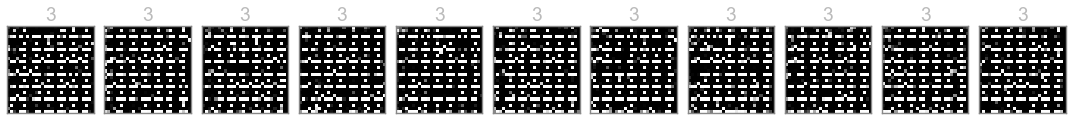

2 / 30 (6.67%)


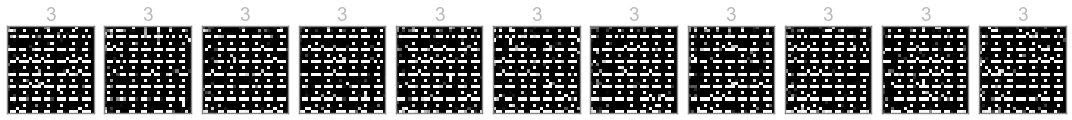

3 / 30 (10.0%)


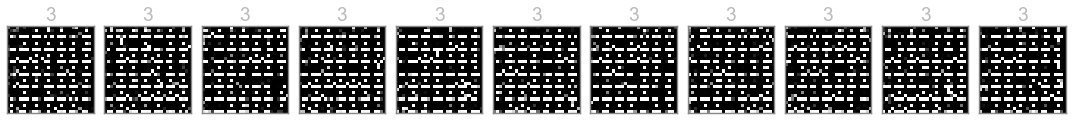

4 / 30 (13.33%)


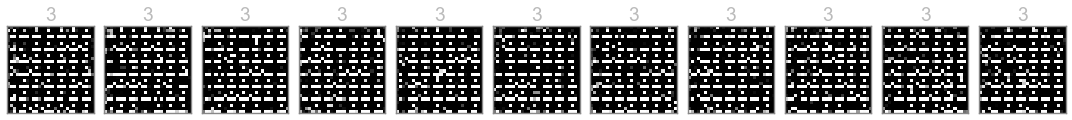

5 / 30 (16.67%)


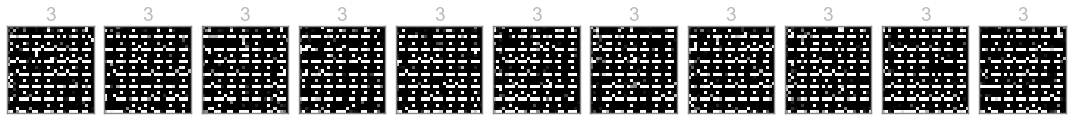

6 / 30 (20.0%)


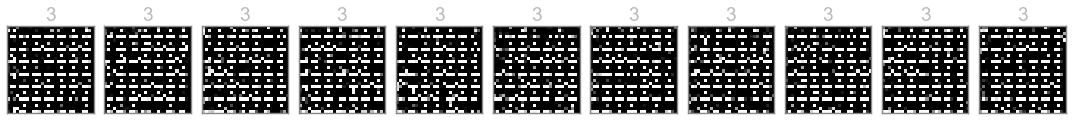

7 / 30 (23.33%)


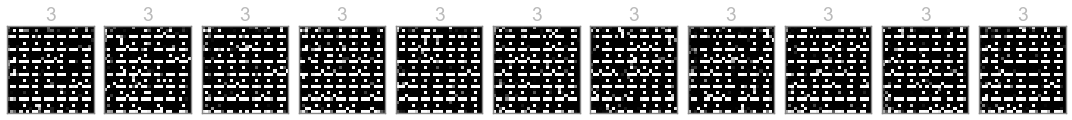

8 / 30 (26.67%)


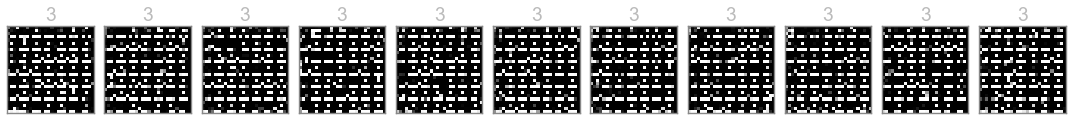

9 / 30 (30.0%)


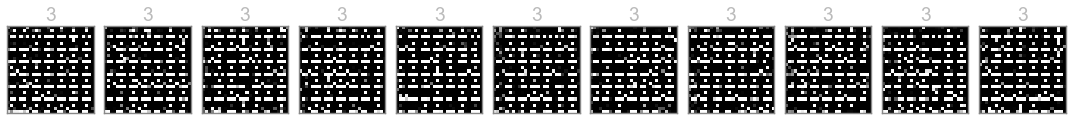

10 / 30 (33.33%)


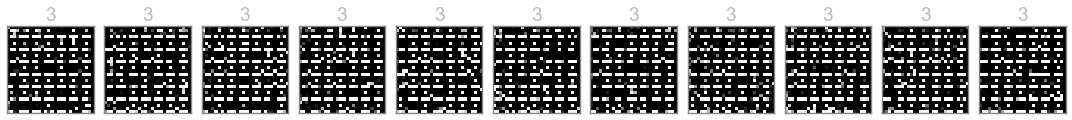

11 / 30 (36.67%)


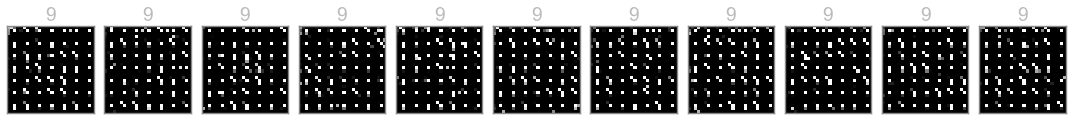

12 / 30 (40.0%)


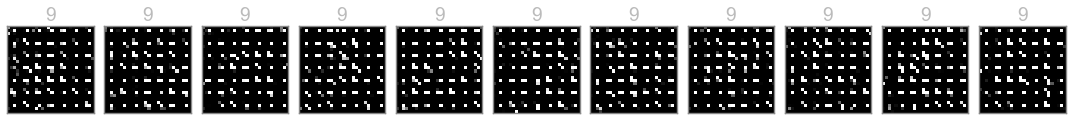

13 / 30 (43.33%)


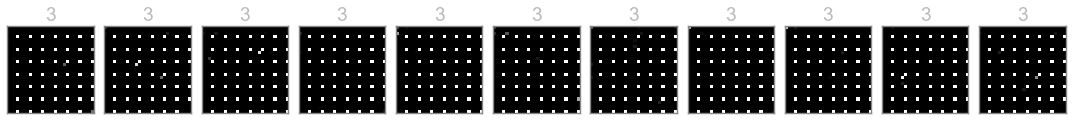

14 / 30 (46.67%)


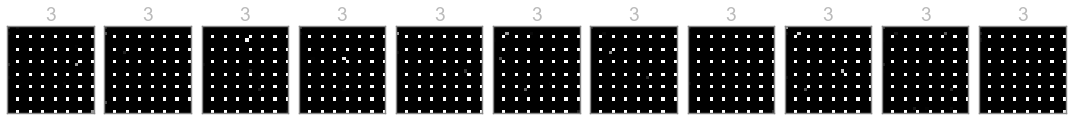

15 / 30 (50.0%)


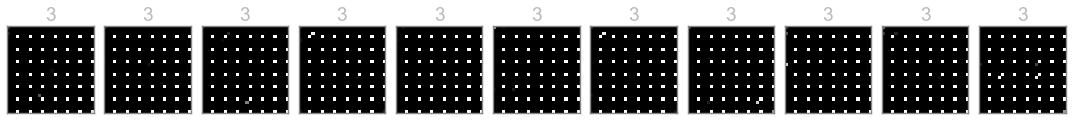

16 / 30 (53.33%)


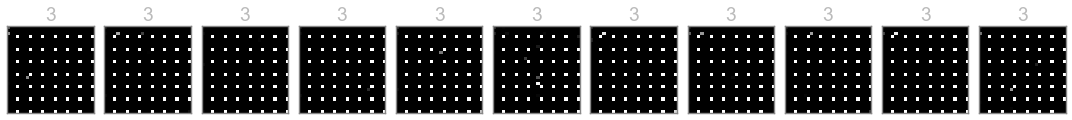

17 / 30 (56.67%)


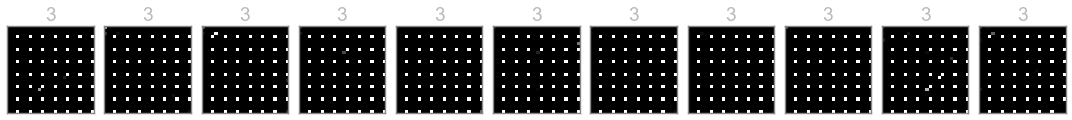

18 / 30 (60.0%)


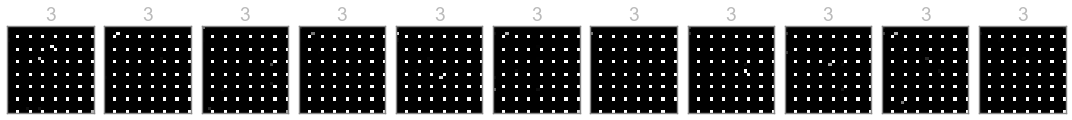

19 / 30 (63.33%)


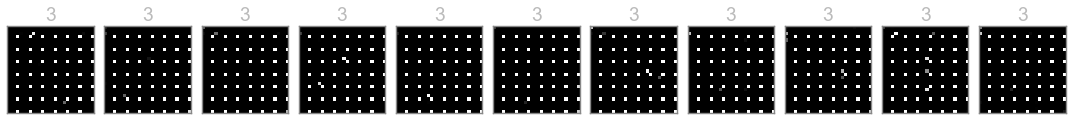

20 / 30 (66.67%)


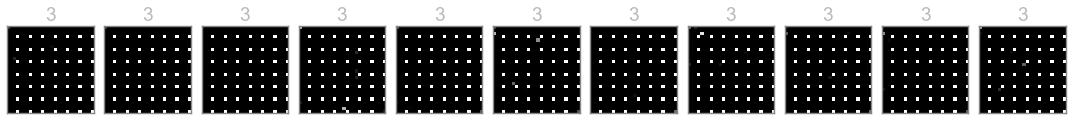

21 / 30 (70.0%)


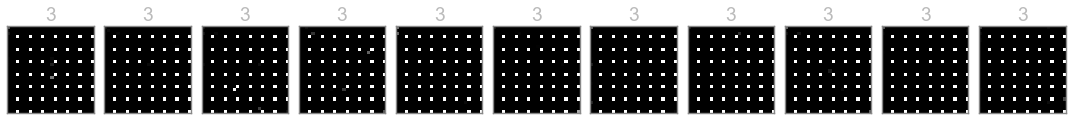

22 / 30 (73.33%)


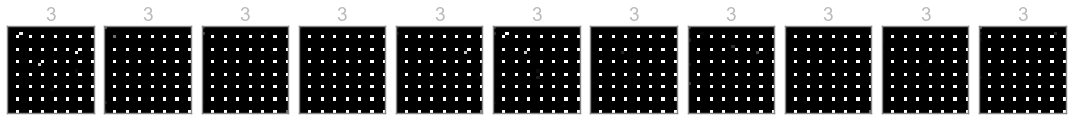

23 / 30 (76.67%)


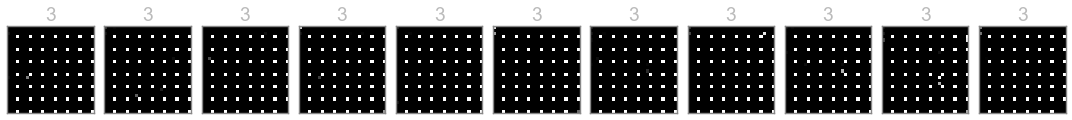

24 / 30 (80.0%)


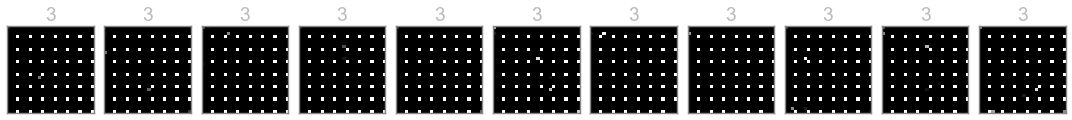

25 / 30 (83.33%)


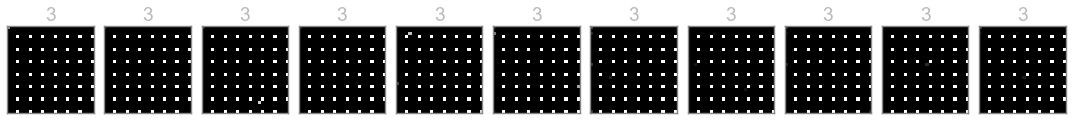

26 / 30 (86.67%)


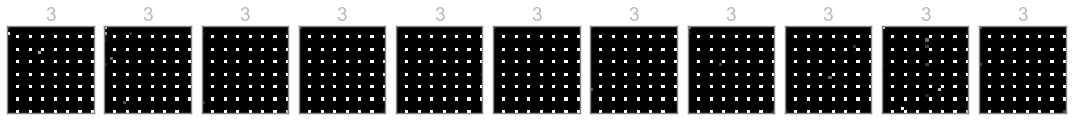

27 / 30 (90.0%)


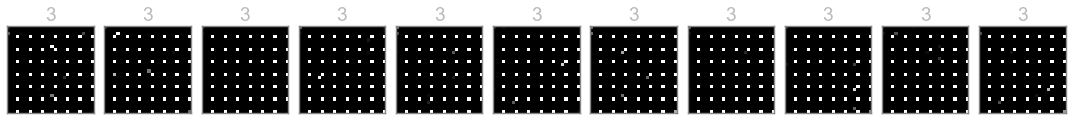

28 / 30 (93.33%)


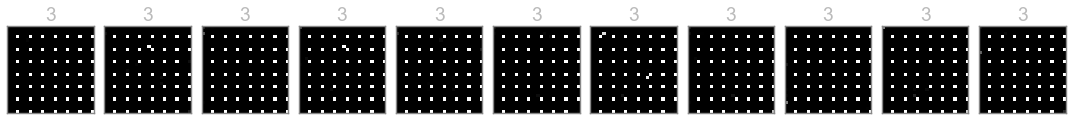

29 / 30 (96.67%)


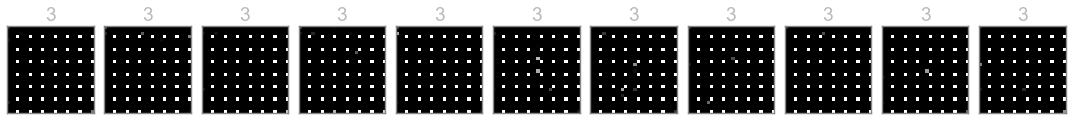

30 / 30 (100.0%)


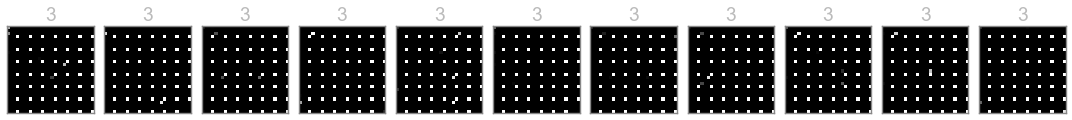

Time taken - 307.82s


In [13]:
if exists('checkpoints/DCGAN-Classifier/DCGAN-Classifier.data-00000-of-00001'):
    with tf.Session(config=config) as sess:
        saver = tf.train.Saver()
        saver.restore(sess, 'checkpoints/DCGAN-Classifier/DCGAN-Classifier')
        
        for _ in range(10):
            plot_generated_images(sess)
else:
    optimize(30)